# K-Means Clustering: RFM Data

In [2]:
"Import the required libraries"
#data manipulation
import pandas as pd
import numpy as np
#Scaler
from sklearn.preprocessing import StandardScaler
#K-means algorithm
from sklearn.cluster import KMeans
#visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
#validation
from sklearn import metrics
#set graphic properties
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_style("whitegrid")

The data used in this part is [rfm.csv]("data/rfm.csv"). The data was cleaned, transformed in the [RFM_Analysis.ipynb]("RFM_Analysis.ipynb"). Please explore that notebook for further details.

In [3]:
#read the rfm data from csv
rfm = pd.read_csv("data/rfm.csv", index_col=[0])

print("The shape of rfm data: " + str(rfm.shape))
rfm.head()

The shape of rfm data: (4372, 9)


,Recency,Frequency,Monetary Value,R,F,M,RFM_Segment,RFM_Score,RFM_Categories
CustomerID,,,,,,,,,
12346.0,325,2,0.00,1,2,1,121,4,Low
12347.0,1,7,4310.00,4,4,4,444,12,Top
12348.0,74,4,1437.24,2,3,3,233,8,Medium
12349.0,18,1,1457.55,3,1,3,313,7,Medium
12350.0,309,1,294.40,1,1,2,112,4,Low


For this part of the analysis only Recency, Frequency, Monetary Value columns are required. Therefore, rest of the columns can be dropped.

In [4]:
#drop the unnecessary columns
rfm = rfm.iloc[:, 0:3]
rfm.head()

,Recency,Frequency,Monetary Value
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,7,4310.00
12348.0,74,4,1437.24
12349.0,18,1,1457.55
12350.0,309,1,294.40


## 1. Data Pre-processing 

Since K-Means clustering will be used for segmentation, one important thing to take into conideration is all variables have comparable means and variance. If the variables do not have comparable means and variance K-Means will assign more weight to some variables than others.

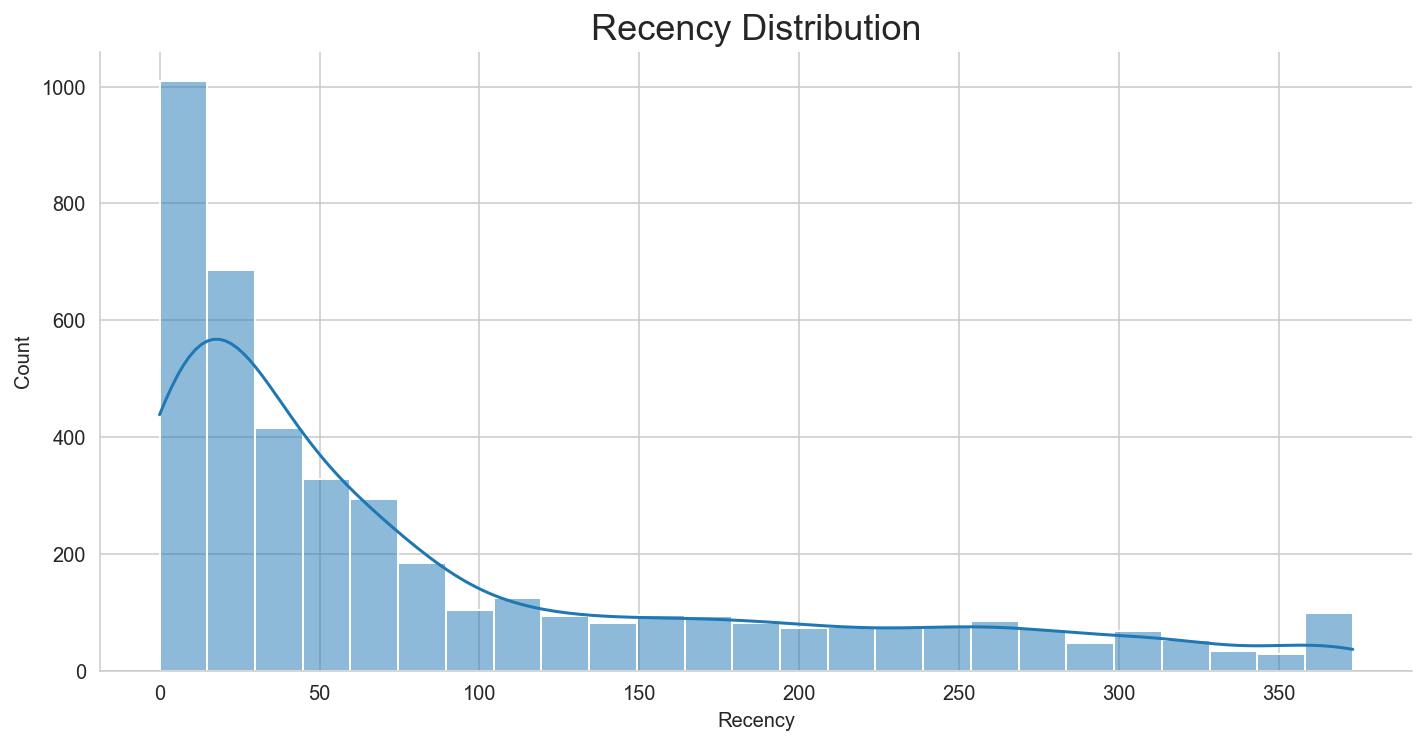

In [5]:
sns.displot(rfm['Recency'], kde = True, height=5, aspect=2);
plt.title("Recency Distribution", fontsize=18);

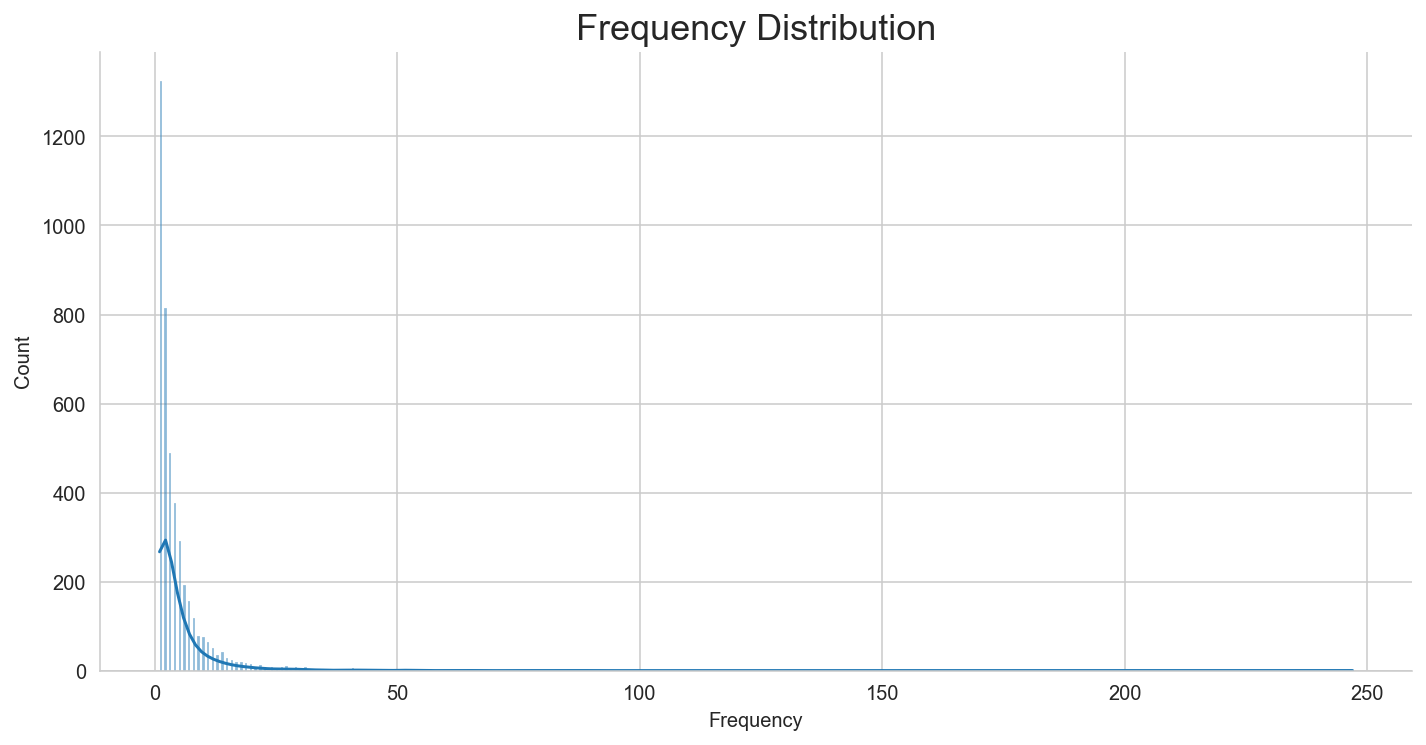

In [6]:
sns.displot(rfm['Frequency'], kde = True, height=5, aspect=2);
plt.title("Frequency Distribution", fontsize=18);

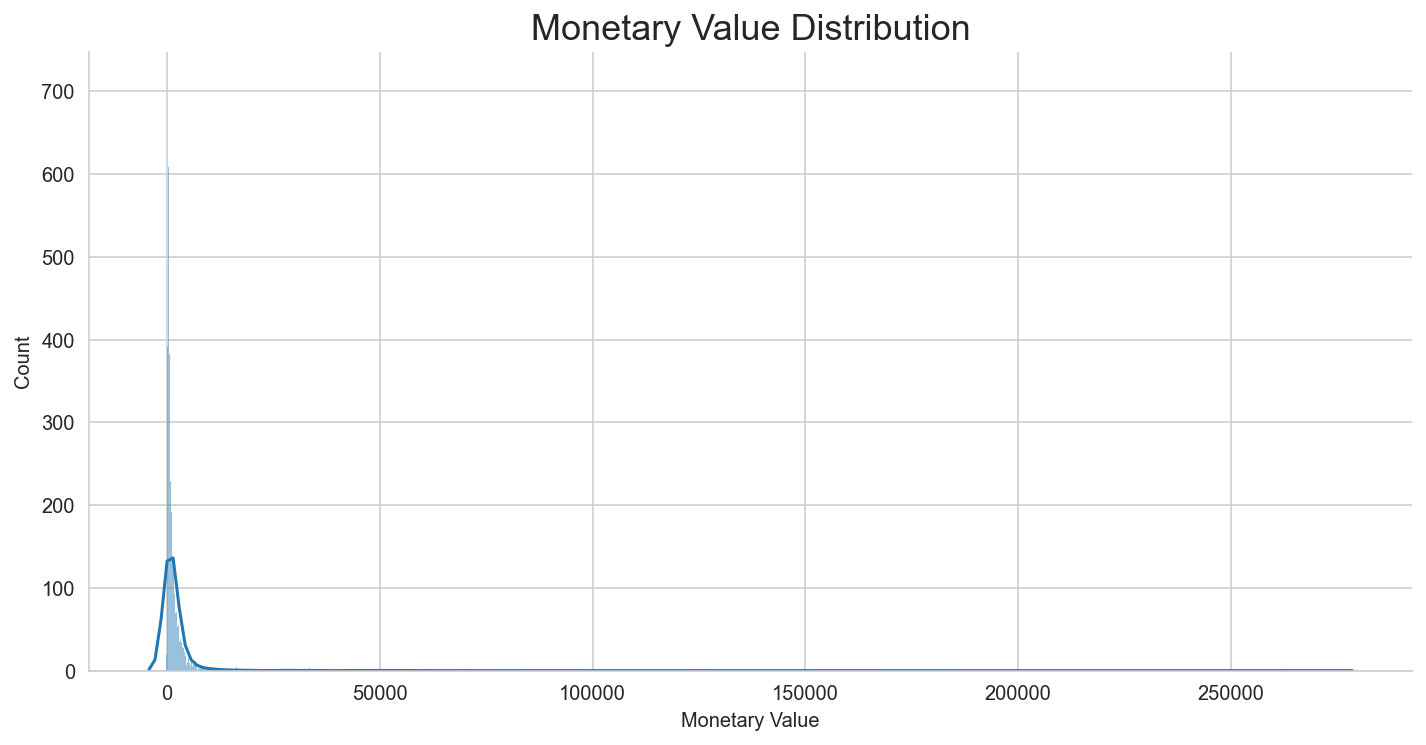

In [7]:
sns.displot(rfm['Monetary Value'], kde = True, height=5, aspect=2);
plt.title("Monetary Value Distribution", fontsize=18);

From the above distribution plots it is apparent that Recency, Frequency and Monetary values are right skewed. Therefore, the values have to be log transformed. However, for values to be log-transformed the values have to be non-zero and non-negative.

In [8]:
#check for zero values
(rfm == 0).sum(axis=0)

Recency           105
Frequency           0
Monetary Value      7
dtype: int64

In [9]:
#check for negative values
(rfm < 0).sum(axis=0)

Recency            0
Frequency          0
Monetary Value    43
dtype: int64

In [10]:
#deal with zeros by adding a small constant of 0.001
rfm['Recency'] = rfm['Recency'] + 0.001

In [11]:
#to deal with negative values I will be ading 
#the absolute value of the biggest negative and then constant of 0.001
rfm['Monetary Value'] = rfm['Monetary Value'] + abs(rfm['Monetary Value'].min()) + 0.001

In [12]:
#check for zero values again
(rfm == 0).sum(axis=0)

Recency           0
Frequency         0
Monetary Value    0
dtype: int64

In [13]:
#check for negative values again
(rfm < 0).sum(axis=0)

Recency           0
Frequency         0
Monetary Value    0
dtype: int64

In [14]:
log_rfm = np.log(rfm)

In [15]:
log_rfm.describe()

,Recency,Frequency,Monetary Value
count,4372.000000,4372.000000,4372.000000
mean,3.504591,1.065418,8.611836
std,2.174666,0.952453,0.411622
min,-6.907755,0.000000,-6.907755
25%,2.772651,0.000000,8.429022
50%,3.891841,1.098612,8.502241
75%,4.955834,1.609438,8.677771
max,5.921581,5.509388,12.552331


The mean and standard deviations for Recency, Frequency, Monetary Values are still not comparable. Hence, I will be using Standard Scalar, it makes mean = 0 and scales the data to unit variance

## 2. Scaling

In [16]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(log_rfm)

In [17]:
#check the means
rfm_scaled.mean(axis=0).round(1)

array([ 0.,  0., -0.])

In [18]:
#check the std deviation
rfm_scaled.std(axis=0)

array([1., 1., 1.])

## 3. K-Means

In [19]:
#convert scaled rfm values to dataframe
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)
rfm_scaled_df.head()

,Recency,Frequency,Monetary Value
CustomerID,,,
12346.0,1.048206,-0.390899,-0.603406
12347.0,-1.611279,0.924553,1.087059
12348.0,0.367679,0.336934,0.098983
12349.0,-0.282450,-1.118732,0.107588
12350.0,1.024989,-1.118732,-0.442055


In [20]:
def perform_KNN(clusters, rfm):
    '''
    Function to get the distortions(inertia_) and silhouette score for each of the given 
    clusters in the input.
    
    INPUT:
        1. clusters(list): list of clusters to get the distortions and silhouette score.
        2. rfm(pandas dataframe): dataframe with scaled values for R, F, M
        
    OUTPUT:
        1. df(pandas dataframe): dataframe with cluster and its distortions and silhouette score.
    '''
    #define a dataframe
    df = pd.DataFrame(columns=['cluster', "silhouette_Score", "distortions"])
    #loop through the clusters
    for c in clusters:
        cluster = KMeans(n_clusters=c, n_init=100, init='k-means++').fit(rfm)
        #compute the silhouette score
        sh_score = metrics.silhouette_score(rfm, cluster.labels_, metric='euclidean')
        #get the distortions
        distortions = cluster.inertia_
        #assign to the dataframe
        df.loc[len(df)] = [c, sh_score, distortions]
    
    return df

#list of clusters to check
cluster_list = list(range(2, 16))
df_kmeans = perform_KNN(cluster_list, rfm_scaled_df)
df_kmeans

,cluster,silhouette_Score,distortions
0,2.0,0.472518,8044.215884
1,3.0,0.443801,6108.597500
2,4.0,0.446436,4714.690780
3,5.0,0.415026,3514.268178
4,6.0,0.385679,2848.663987
5,7.0,0.383134,2422.766370
6,8.0,0.370594,2069.140371
7,9.0,0.359198,1848.978768
8,10.0,0.375302,1651.413123
9,11.0,0.376652,1487.597037


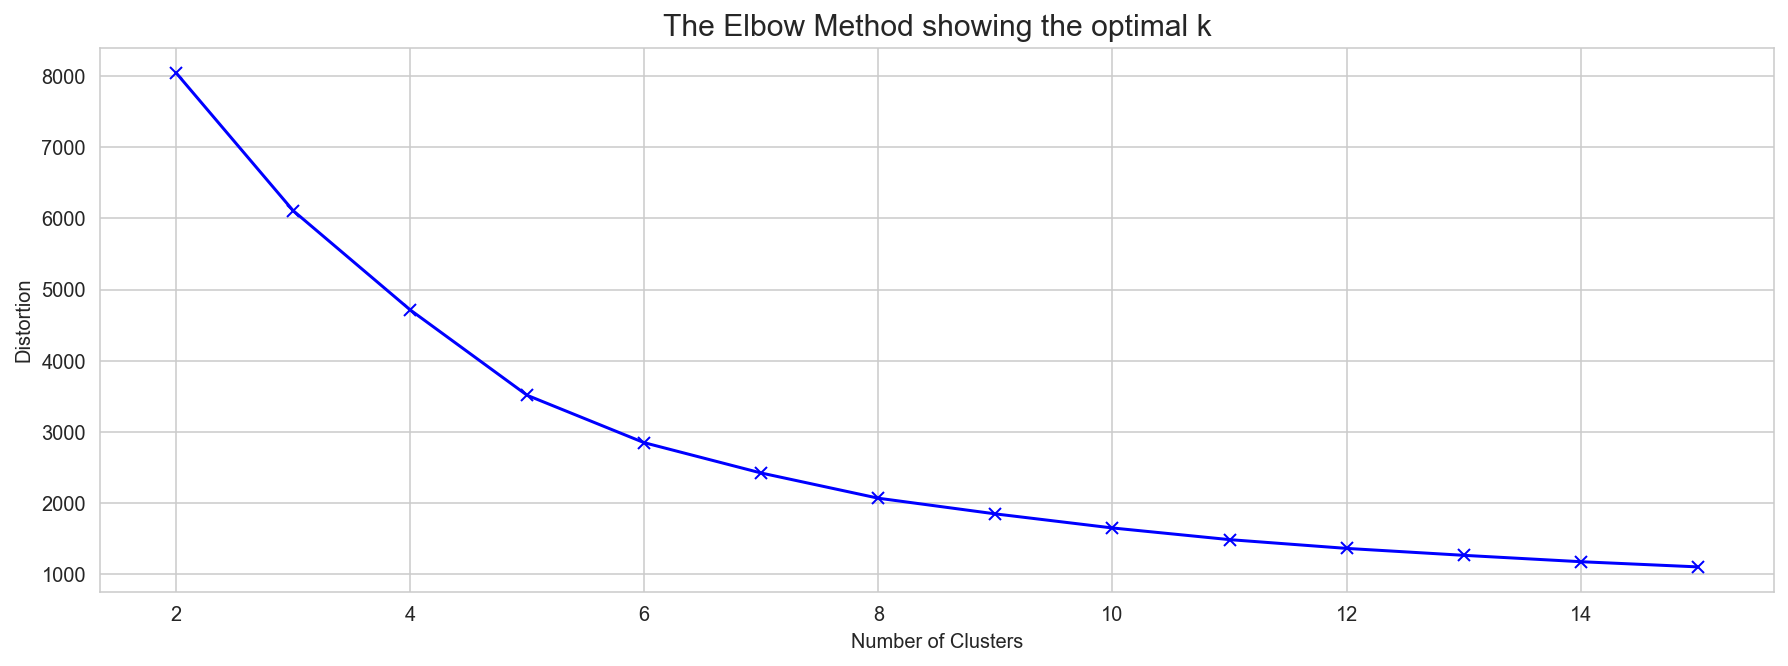

In [26]:
#plot the distortions in elbow graph
plt.figure(figsize=(15,5))
plt.plot(df_kmeans.cluster, df_kmeans.distortions, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k', fontsize = 15)
plt.show()

There is an 'elbow' around cluster 5 and silhouette score for this cluster is good. Therfore, the model will be retrained using clusters = 5. 

In [21]:
#refit the model
rfm_cluster = KMeans(n_clusters=5, n_init=100, init='k-means++').fit(rfm_scaled_df)
#compute the silhouette score
sh_score = metrics.silhouette_score(rfm_scaled_df, rfm_cluster.labels_, metric='euclidean')
print("Silhouette score for cluster = 5: " + str(sh_score))

Silhouette score for cluster = 5: 0.41619704364863647


In [22]:
#add the cluster column to the original dataframe
rfm['Clusters'] = rfm_cluster.labels_.tolist()
rfm.head()

,Recency,Frequency,Monetary Value,Clusters
CustomerID,,,,
12346.0,325.001,2,4287.631,0
12347.0,1.001,7,8597.631,3
12348.0,74.001,4,5724.871,2
12349.0,18.001,1,5745.181,0
12350.0,309.001,1,4582.031,0


### Cluster Analysis

In [24]:
cluster_avg = rfm.groupby(['Clusters']).mean()
cluster_avg

,Recency,Frequency,Monetary Value
Clusters,,,
0,146.851069,1.457196,4684.342384
1,0.001000,21.752381,14307.993381
2,43.516998,5.297266,5704.669396
3,16.107218,19.435233,14287.637554
4,144.001000,1.000000,0.001000


In [25]:
population_avg = rfm.mean()
population_avg

Recency             91.151046
Frequency            5.041629
Monetary Value    6163.439612
Clusters             1.076167
dtype: float64

In [26]:
# subtract 1 ensures that 0 is returned if cluster_avg=population_avg
relative_importance = (cluster_avg/population_avg - 1).round(2)
relative_importance

,Clusters,Frequency,Monetary Value,Recency
Clusters,,,,
0,NaN,-0.71,-0.24,0.61
1,NaN,3.31,1.32,-1.00
2,NaN,0.05,-0.07,-0.52
3,NaN,2.85,1.32,-0.82
4,NaN,-0.80,-1.00,0.58


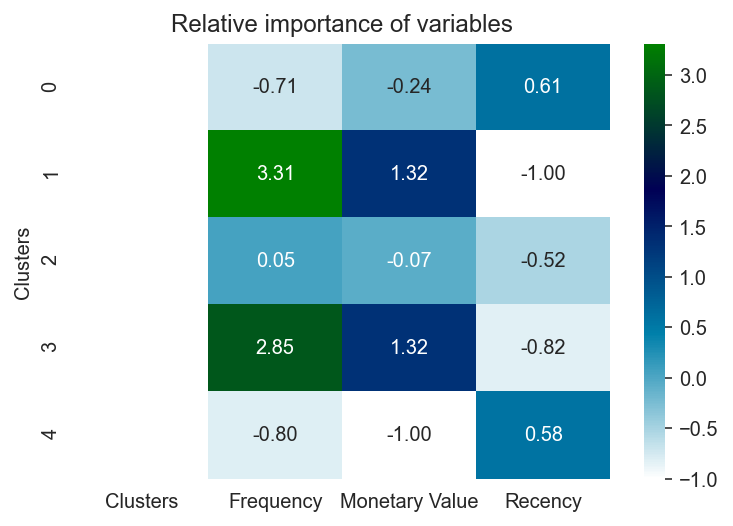

In [27]:
plt.title("Relative importance of variables");
sns.heatmap(relative_importance, annot=True, fmt='.2f', cmap='ocean_r');

#### Analysis of 5 clusters:

1. Cluster 0: Recency is the most important for this group
2. Cluster 1: Frequency is the most important in this group as compared to any other groups, followed by Monetary Value.
3. Cluster 2: Frequencey is the only metric important in this group.
4. Cluster 3: Similar to cluster 1 Frequency and Monetary Value is important for customers in this group.
5. Cluster 4: Recency is the most important for this group